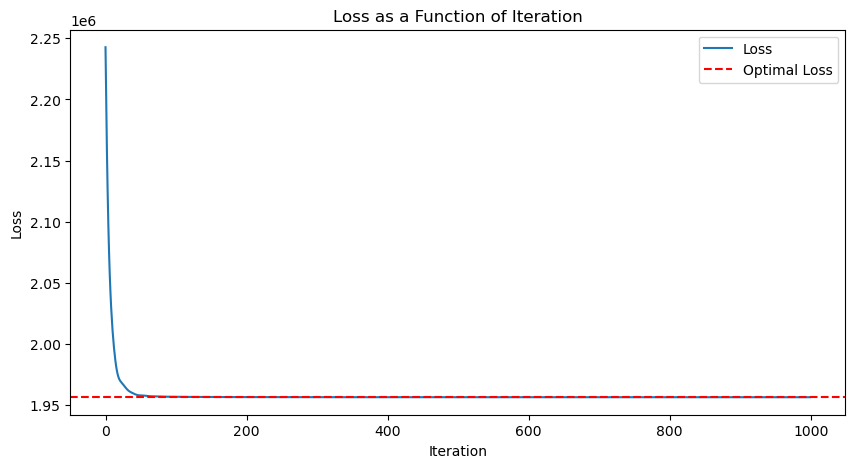

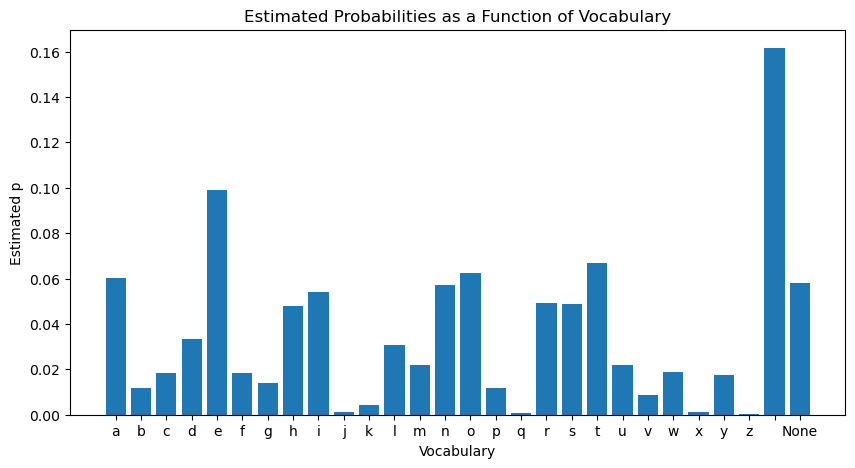

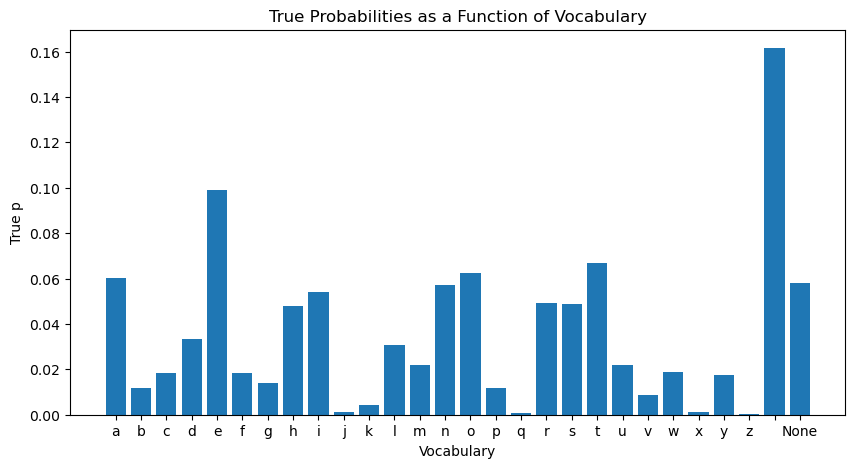

In [1]:
"""Pytorch."""
import nltk
import numpy as np
from numpy.typing import NDArray
import torch
from typing import List, Optional
from torch import nn
import matplotlib.pyplot as plt
from collections import Counter

FloatArray = NDArray[np.float64]


def onehot(vocabulary: List[Optional[str]], token: Optional[str]) -> FloatArray:
    """Generate the one-hot encoding for the provided token in the provided vocabulary."""
    embedding = np.zeros((len(vocabulary), 1))
    try:
        idx = vocabulary.index(token)
    except ValueError:
        idx = len(vocabulary) - 1
    # setting the value at the row idx and column 0 of the embedding array to 1
    embedding[idx, 0] = 1
    return embedding


# logit converts the y in sigmoid graph from [0,1] to real numbers


def logit(x: FloatArray) -> FloatArray:
    """Compute logit (inverse sigmoid)."""
    return np.log(x) - np.log(1 - x)


# normalize makes the whole function into a distribution to sum up to 1
# converting the input tensor into a probability distribution.


def normalize(x: torch.Tensor) -> torch.Tensor:
    """Normalize vector so that it sums to 1."""
    return x / torch.sum(x)


# The log function x closer to 0 y is a negative number (closer to 0 is the optimal value)
# - log value to better visualize it .


def loss_fn(p: float) -> float:
    """Compute loss to maximize probability."""
    return -p


class Unigram(nn.Module):
    def __init__(self, V: int):
        super().__init__()
        # construct initial s - corresponds to the logit transfromation of uniform distribution p to real numbers
        s0 = logit(np.ones((V, 1)) / V)
        # the actual parameter of the model, which is initialized with s0 and will be optimized during the training process
        self.s = nn.Parameter(torch.tensor(s0.astype("float32")))

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        # After the optimization process, applying the sigmoid function to self.s would give the learned probabilities for each token in the unigram model between [0,1].
        # convert s to proper distribution p (normalize)
        p = normalize(torch.sigmoid(self.s))
        # compute freqeuncy of each token X log(prob) to get the whole probability
        return torch.sum(input, 1, keepdim=True).T @ torch.log(p)


def gradient_descent_example():
    """Demonstrate gradient descent."""
    # generate vocabulary
    vocabulary = [chr(i + ord("a")) for i in range(26)] + [" ", None]
    # generate training document
    text = nltk.corpus.gutenberg.raw("austen-sense.txt").lower()
    # tokenize - split the document into a list of little strings
    tokens = [char for char in text]
    # generate one-hot encodings - a V-by-T array
    encodings = np.hstack([onehot(vocabulary, token) for token in tokens])
    # convert training data to PyTorch tensor
    x = torch.tensor(encodings.astype("float32"))
    # define model
    model = Unigram(len(vocabulary))
    # set number of iterations and learning rate
    num_iterations = 1000
    learning_rate = 0.1
    loss_history = []
    # train model
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for _ in range(num_iterations):
        p_pred = model(x)
        loss = -p_pred
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
        # Append the loss value to the list
        # Extract the loss value for this iteration and append it to the list
        loss_value = loss.item()  # Extract the loss value
        loss_history.append(loss_value)
    # get the loss history
    # print(loss_history)
    rows = torch.sum(x, dim=1)
    # get the optimal_prob, which is the true probabilities
    optimal_prob = rows / (torch.sum(rows))
    optimal_prob_list = [a.item() for a in optimal_prob]
    # get optimal_loss
    optimal_loss = (torch.sum(x, 1, keepdim=True).T @ torch.log(optimal_prob)) * -1
    optimal_loss_list = [a.item() for a in optimal_loss]
    # print(f"Optimal Loss: {optimal_loss}")
    # get the estimated probabilities
    estimates_probability = normalize(torch.sigmoid(next(model.parameters())))
    estimated_probability_cleaned = [a.item() for a in estimates_probability]
    # print(estimated_probability_cleaned)
    # loss visualizations
    plt.figure(figsize=(10, 5))
    # plot loss hisotry
    plt.plot(loss_history, label="Loss")
    # plot optimal lose line
    plt.axhline(y=optimal_loss_list, color="r", linestyle="--", label="Optimal Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss as a Function of Iteration")
    plt.show()
    vocabulary_cleaned = [chr(i + ord("a")) for i in range(26)] + [" ", "None"]
    # Estimated probabilities visualizations
    plt.figure(figsize=(10, 5))
    plt.bar(vocabulary_cleaned, estimated_probability_cleaned, align="center")
    plt.xlabel("Vocabulary")
    plt.ylabel("Estimated p")
    plt.title("Estimated Probabilities as a Function of Vocabulary")
    plt.show()
    # True Probabilities visualization
    plt.figure(figsize=(10, 5))
    plt.bar(vocabulary_cleaned, optimal_prob_list, align="center")
    plt.xlabel("Vocabulary")
    plt.ylabel("True p")
    plt.title("True Probabilities as a Function of Vocabulary")
    plt.show()


if __name__ == "__main__":
    gradient_descent_example()